# Use Case 1 : Time Series
<br>

**Dataset** : Annual Water Usage in Baltimore. 
<br>
You can download it here
https://drive.google.com/open?id=1axM3gfGxQq4T0wuwP51DVMQAecVFmpxL

<br>
The dataset is credited to Hipel an Mcleod, 1994.
<br>

**Background** : The Dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.
The values are in the units of liters per capita per day, and there are 79 observations.
<br>
**Objective** : Create a python script for the Use Case below, please upload the script after you finish.
The Problem is to predict annual water usage.

**Instructions** :
<br>
1. Load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).
2. Create summary of the dataset, with python function.
3. Create A line plot of a time series dataset, it will provide a lot of insight into the problem.
4. Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.
5. Create models using **ARIMA**
    - Split the dataset into train and test sets directly
    - The first 50% of the dataset will be held back to train the model.
    - The remaining 50% of the dataset will be iterated and test the model.
    - The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.
    - Use an ARIMA(0,1,0) on the raw data may be a good starting point.
    - When model trained, a one-step prediction made ang the prediction stored for later evaluation.
    - The actual observation from the test dataset woll be added to the training dataset for the next iteration.
    - The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.
    - Calculate the RMSE using the helper function from the scikit-learn library, from dataset only
    - Those RMSE will show you on average, how much the error/the model was wrong/gap between predection and expected value per capita per day for each prediction made.


<br><br>
First, we import the necesary modules/packages

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime                              # For changing from string to time format


from statsmodels.tsa.arima_model import ARIMA              # ARIMA model
from sklearn.metrics import mean_squared_error,mean_absolute_error   # For model evaluation
import warnings
warnings.filterwarnings("ignore")

<br>

## 1. Importing and Splitting Data

<br>
Before we spliting our data, we clean our data to remove duplicates and Null value. Also, we change the format of **Year** into datetime

In [116]:
data = pd.read_csv('water.csv',delimiter =';',skipfooter=2)
data.columns=['Year','Baltimore Annual Water Use']
data.head()

,Year,Baltimore Annual Water Use
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


In [117]:
# Data Preprocessing, cek Null and Duplicate
print(data.info())
print('\n')
print('Number of duplicate (true=there is duplicate)')
print(pd.DataFrame(data.duplicated(subset='Year', keep='first')).iloc[:,0].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
Year                          77 non-null int64
Baltimore Annual Water Use    77 non-null int64
dtypes: int64(2)
memory usage: 1.3 KB
None


Number of duplicate (true=there is duplicate)
False    77
Name: 0, dtype: int64


<br>
From here, we see that there are 77 non-null data in each columns, and with dimension (77,2) it means there are no null data and no duplicate in our data. So we move on to next step, changing **Year** into datetime

In [118]:
f="%Y"
data['Year']=data['Year'].astype('str')
data['Year']=data['Year'].apply(lambda x:datetime.strptime(x,f))
data.head()

,Year,Baltimore Annual Water Use
0,1885-01-01,356
1,1886-01-01,386
2,1887-01-01,397
3,1888-01-01,397
4,1889-01-01,413


<br><br>
We are spliting our data into *dataset (data_t)* and *validation (data_v)* using ration 85% and 15% respectively. dataset is used to train our model and validation for further analyze our model forecasting results

In [122]:
data=data.set_index('Year')
data.index=data.index.year
data_t=data.iloc[:(round(data.shape[0]*0.85)+1),:]
data_v=data.iloc[(round(data.shape[0]*0.85)+1):,:]
print('Last Year in dataset : ',data_t.index[-1])
print('First Year Validation : ',data_v.index[0])

Last Year in dataset :  1950
First Year Validation :  1951


<br><br>
With last year in dataset 1950 and first year in dataset 1951, it means our data's spliting perfectly split our original data.

In [108]:
data_t.to_csv(r'dataset.csv')
data_v.to_csv(r'validation.csv')


## 2. Create Summary of data

<br>
Using .describe for dataframe *pandas*, we create a summary for our data_t (or dataset)

In [120]:
print('Min Year :', min(data_t.index))
print('Max Year :', max(data_t.index))

data_t.describe()

Min Year : 1885
Max Year : 1950


,Baltimore Annual Water Use
count,66.000000
mean,498.212121
std,74.755296
min,344.000000
25%,458.000000
50%,492.000000
75%,525.000000
max,662.000000


<br><br>
Our dataset (or data_t) has interval 1885-1950 and water use ranging from 344 to 662. It's mean is 498.212, with standard deviation 74,76 which means in general, Baltimore Annual Water use from these interval ranging from 498.21-74.76 to 498.21+74.76. 

<br>

## 3. Create a line plot of dataset (data_t)

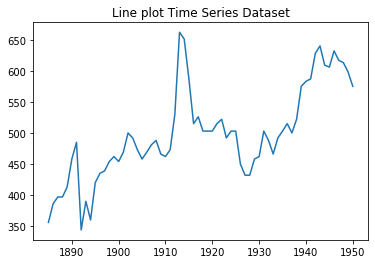

In [125]:
plt.title('Line plot Time Series Dataset')
plt.plot(data_t)
plt.show()

<br><br>
Here, we see that our data kinda has season, and also has trend. While season means that we need use another model (like Seasonal ARIMA (SARIMA) ) or transforming our data, for now, we are following the instruction above. 

## 4. Group and see the data by decade

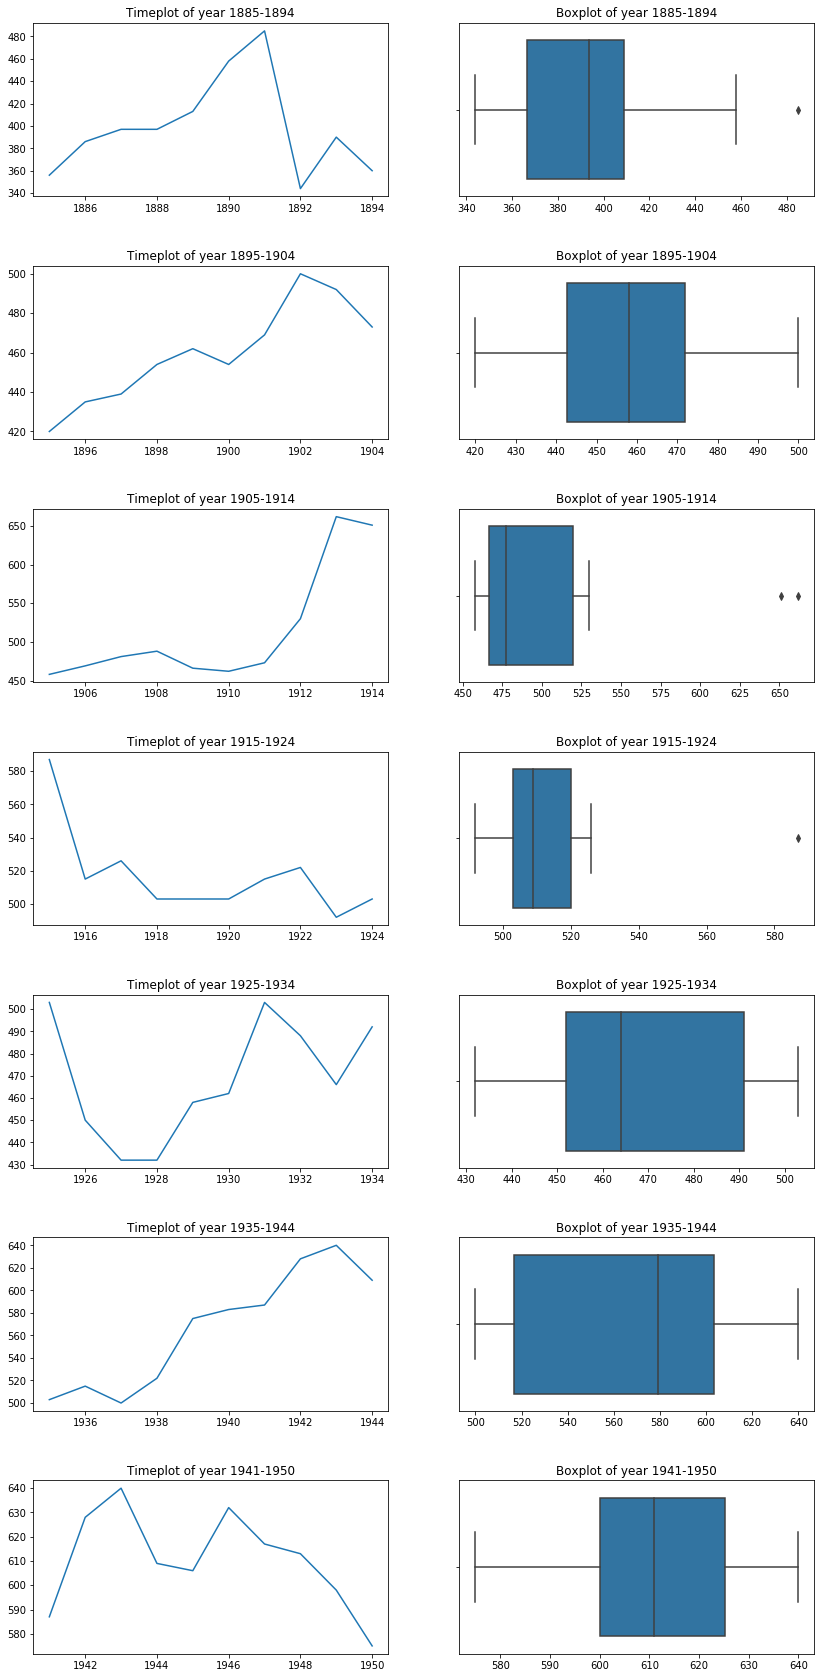

In [135]:
f=plt.figure(figsize=(14,30))

j=1
for i in range(data_t.shape[0]):
    if (i+1)%10==0 or (i==65):
        f.add_subplot(7,2,j)
        plt.subplots_adjust(hspace=0.4)
        plt.title('Timeplot of year {}-{}'.format(data.index[i-9],data.index[i]))
        plt.plot(data.iloc[list(range(i-9,i+1)),:])
        j+=1
        
        f.add_subplot(7,2,j)
        plt.subplots_adjust(hspace=0.4)
        plt.title('Boxplot of year {}-{}'.format(data.index[i-9],data.index[i]))
        sns.boxplot(data.iloc[list(range(i-9,i+1)),:])
        j+=1
plt.show()

<br><br>
From above, we see the spread of observation on each decade and line plot of eah decade. We see that in each decade, the pattern in line plot is hard to find. Also in boxplot, we see that mostly our data spread ranging from 20 to 80 annual water.

<br>
Notes, that if we try differencing our data, we get more stationer data (especially in means). Thats, why we use d=1 or differencing = 1 in our next step, building our model

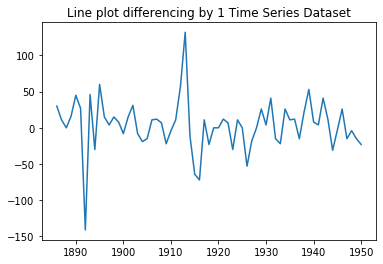

In [190]:
diff=data_t-data_t.shift(periods=1)

plt.title('Line plot differencing by 1 Time Series Dataset')
plt.plot(diff)
plt.show()

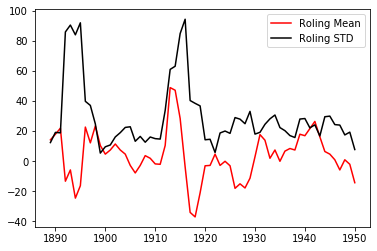

In [191]:
rolmean=diff.rolling(window=4).mean()
rolstd=diff.rolling(window=4).std()
plt.plot(rolmean,color='red',label='Roling Mean')
plt.plot(rolstd,color='black',label='Roling STD')
plt.legend(loc='best')
plt.show()

<br>
Looks like even by differencing, our data still not stationer. We can improve this by differencing more, or using transformation. But for now, we stick to instruction instead

In [194]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller

print('Dickey-fuller test')
dftest=adfuller(data_t[data_t.columns[0]],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Stat','p-value','lag_used','number of obs used'])
dfoutput

Dickey-fuller test


Test Stat             -2.081461
p-value                0.252034
lag_used               2.000000
number of obs used    63.000000
dtype: float64

<br>
Our data also not stationer by variance. Again, we can improve this by using transformation. But for now, we use original data instead

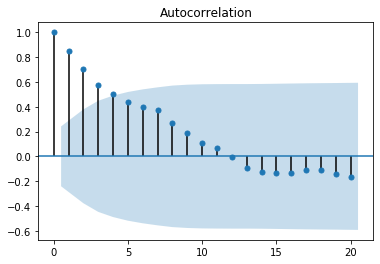

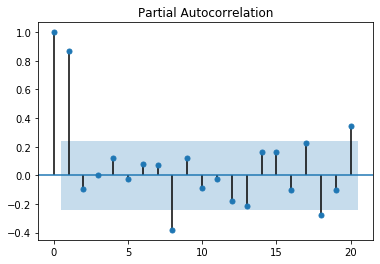

In [195]:
import statsmodels.graphics.tsaplots as sts
sts.plot_acf(data_t,lags=20)
sts.plot_pacf(data_t,lags=20)
plt.show()


<br><br>
By plotting ACF and PACF, we see that our AR model is sinusidal but our PACF is unclear. There are no cut-off in PACF as in lag-8 there are point above pacf interval limit. This is a strong evidence that there are outliers in our data. As we see that are sudden jump in some year, indicating random noise in our data. For that, we use search p,d,q order in ARIMA by manual

## 5. Create Models ARIMA

### Spliting our dataset into train and test

In [138]:
# Time Series
length=round(0.5*data_t.shape[0])+1
train = data_t.iloc[:length,:]
test = data_t.iloc[length:,:]
print('Last year of train :',train.index[-1])
print('Last year of test : ',test.index[0])

Last year of train : 1918
Last year of test :  1919


<br><br>
Now, we build our ARiMA model. Normally, we should see its ACF and PACF to determine *(p,d,q)* in our data. But, we follow above instruction instead. We use iteration to determine our model. Notes that below algorithm, we use Mean Squared Error of iteration validation, which is : "Given model arima (p,d,q), we find its model performance by training our model first by using 33 train, 33 test to find one year prediction of our model second by 34 train, 32 test, and so on until 66 train and 0test. Then, each prediction of our iteration will be compared to our original test data to find its MSE". <br>
You can see below comment to further see the explanation of our algorithm.

In [48]:
# Creating data to compared the result 
Result=pd.DataFrame(columns=['Model','MSE Train','MSE Test','MSE iteration'])
test_size= len(test.iloc[:,0])
train_size= len(train.iloc[:,0])


for i in range(0,7):       # used for p in ARIMA(p,1,q)
    for j in range(0,7):   # used for q in ARIMA(p,1,q)
        models=[i,1,j]
        print(models)    # We print each result to see the progress of our algorithm
        time=train.iloc[:,0]
        model=ARIMA(np.float64(time),order=models)
        try:                                             # if error, then continue to the next j 
            result_ARIMA=model.fit()                  
        except:
            continue
        predict_train=result_ARIMA.fittedvalues
        MSE_train = mean_squared_error(time[1:],predict_train+time.shift()[1:])
        predict_test=result_ARIMA.forecast(len(test.iloc[:,0]))[0]
        MSE_test = mean_squared_error(test.iloc[:,0],predict_test)
            
        a=pd.DataFrame(columns=['Model','MSE Train','MSE Test','MSE iteration'])
        a['Model']=[models]
        a['MSE Train']=[MSE_train]
        a['MSE Test']=[MSE_test]
        
        
        # For result of training by iteration of test
        pred=[]
        for n in range(0,test_size,1):
            time=data.iloc[:(n+train_size),0]
            model=ARIMA(np.float64(time),order=models)
            try:
                result_ARIMA=model.fit()
            except:
                continue
            y_pred = result_ARIMA.forecast(1)[0]
            pred.append(y_pred[0])

        try:
            MSE_iter=mean_squared_error(test,pred)
            a['MSE iteration']=[MSE_iter]
        except:
            continue
             
        Result=Result.append(a,ignore_index=True)
        
        
Result.sort_values('MSE iteration').head()

[0, 1, 0]
[0, 1, 1]
[0, 1, 2]
[0, 1, 3]
[0, 1, 4]
[0, 1, 5]
[0, 1, 6]
[1, 1, 0]
[1, 1, 1]
[1, 1, 2]
[1, 1, 3]
[1, 1, 4]
[1, 1, 5]
[1, 1, 6]
[2, 1, 0]
[2, 1, 1]
[2, 1, 2]
[2, 1, 3]
[2, 1, 4]
[2, 1, 5]
[2, 1, 6]
[3, 1, 0]
[3, 1, 1]
[3, 1, 2]
[3, 1, 3]
[3, 1, 4]
[3, 1, 5]
[3, 1, 6]
[4, 1, 0]
[4, 1, 1]
[4, 1, 2]
[4, 1, 3]
[4, 1, 4]
[4, 1, 5]
[4, 1, 6]
[5, 1, 0]
[5, 1, 1]
[5, 1, 2]
[5, 1, 3]
[5, 1, 4]
[5, 1, 5]
[5, 1, 6]
[6, 1, 0]
[6, 1, 1]
[6, 1, 2]
[6, 1, 3]
[6, 1, 4]
[6, 1, 5]
[6, 1, 6]


,Model,MSE Train,MSE Test,MSE iteration
7,"[2, 1, 0]",1921.816764,3656.775039,505.831631
1,"[0, 1, 1]",1937.990662,3537.933855,521.209424
6,"[1, 1, 0]",1938.035677,3543.154743,521.456487
0,"[0, 1, 0]",1938.247934,3569.156250,521.695919
8,"[3, 1, 0]",1658.041246,7859.460000,643.579841


<br><br>
WE see that model [2,1,0] is the best ARIMA model for our data, with MSE iteration which is MSE using train test iteration 505.83. 

In [139]:
# Best Model ARIMA[2,1,0]
pred=[]
models=[2,1,0]
test_size= len(test.iloc[:,0])
train_size= len(train.iloc[:,0])

for n in range(0,test_size,1):
    time=data.iloc[:(n+train_size),0]
    model=ARIMA(np.float64(time),order=models)
    result_ARIMA=model.fit()
    y_pred = result_ARIMA.forecast(1)[0]
    pred.append(y_pred[0])
    
compa=pd.DataFrame(columns=['Prediction','Real'],index=test.index)
compa['Prediction']=pred
compa['Real']=test
compa

,Prediction,Real
Year,,
1919,506.539382,503
1920,509.686308,503
1921,507.453465,515
1922,519.820656,522
1923,525.780087,492
1924,494.874873,503
1925,509.868033,503
1926,505.933520,450
1927,452.049283,432


<br><br>Here we see the comparion of our prediction and real test data. We see that for some year, our prediction is very close

In [88]:
print('Root Mean Squared Error :',np.sqrt(mean_squared_error(test,pred)))

Root Mean Squared Error : 22.4907009959698


<br><br>
RMSEE 22.49 means that on average, there are gap of 22.49 between our prediction and real test data

<br><br>
Now, we use *validation.csv* to validate our model's prediction

In [140]:
models=[2,1,0]
time2=data_t.iloc[:,0]

model=ARIMA(np.float64(time2),order=models)
result_ARIMA=model.fit()
predict=result_ARIMA.fittedvalues
print('RMSE training model : ',np.sqrt(mean_squared_error(time2[1:],predict+time2.shift()[1:])))

y_pred=result_ARIMA.forecast(data_v.shape[0])[0]
print('RMSE Validation: ',np.sqrt(mean_squared_error(data_v,y_pred)))

RMSE training model :  34.890867088001094
RMSE Validation:  26.5533360862091


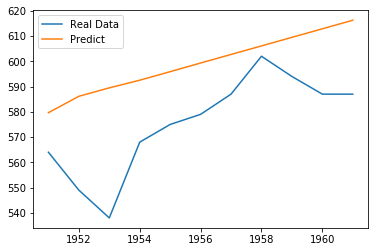

In [141]:
pred_data=pd.DataFrame(columns=['pred'],index=data_v.index)
pred_data['pred']=y_pred

plt.plot(data_v,label='Real Data')

plt.plot(pred_data.index,pred_data,label='Predict')
plt.legend()

<br><br>
We find that using ARIMA(2,1,0), we find that RMSE for validation is 26.5. It means that our model has on average 26.5 gap between observation and prediction. Using this model, we can further forecast our data further. It is best to using iteration to forecast data (by appending training data with our forecasting prediction)

In [181]:
# Best Model ARIMA[2,1,0]
pred=[]
models=[2,1,0]
test_size= len(data_v.iloc[:,0])
train_size= len(data_t.iloc[:,0])
time=data_t
for n in range(0,test_size,1):
    model=ARIMA(np.float64(time),order=models)
    result_ARIMA=model.fit()
    y_pred = result_ARIMA.forecast(1)[0]
    pred.append(y_pred[0])
    time=data.iloc[:(n+train_size),0].append(pd.DataFrame(y_pred,index=[data_v.index[n]]))
    
compa=pd.DataFrame(columns=['Prediction','Real'],index=data_v.index)
compa['Prediction']=pred
compa['Real']=data_v
print('RMSE Validation : ',np.sqrt(mean_squared_error(compa['Real'],compa['Prediction'])))
compa

RMSE Validation :  33.09971405339372


,Prediction,Real
Year,,
1951,579.662195,564
1952,586.152078,549
1953,591.894841,538
1954,598.662917,568
1955,605.769169,575
1956,607.921343,579
1957,612.287849,587
1958,616.949517,602
1959,621.092688,594


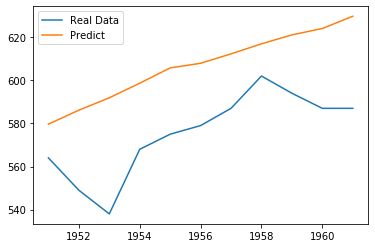

In [182]:
plt.plot(compa['Real'],label='Real Data')

plt.plot(compa.index,compa['Prediction'],label='Predict')
plt.legend()

<br><br>
We see that our prediction becomes more accurate. It's best to forecasting using timeseries this way, as our training data become more accurate to forecast validation.csv